In [1]:
import numpy as np
from matplotlib import pyplot as plt

import gsw_lib
import sim_lib

res_dir = 'results/gsw'
prefices = ['Grass', 'Sheep', 'Wolves']

size_test = [100, 500, 1000, 5000, 10000, 15000, 20000]
# Control CPUs; or None to use all
num_workers = None

In [2]:
sim_lib.start_pool(num_workers)
results_time, data_nl = gsw_lib.load_data(prefices, res_dir + '/netlogo', 1, max(size_test), pool=sim_lib.get_pool())
_, data_ml = gsw_lib.load_data(prefices, res_dir + '/matlab', 1, max(size_test), pool=sim_lib.get_pool())
_, data_py = gsw_lib.load_data(prefices, res_dir + '/python', 0, max(size_test), pool=sim_lib.get_pool())

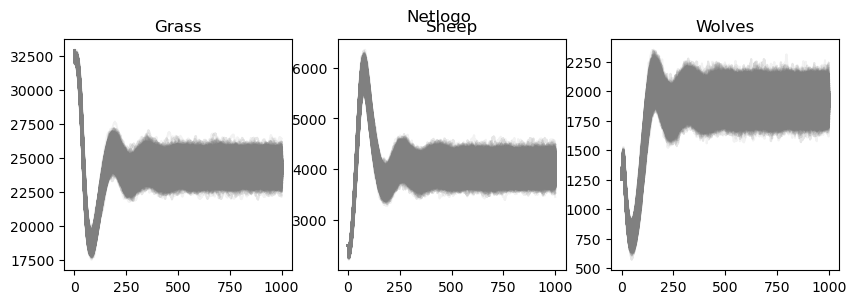

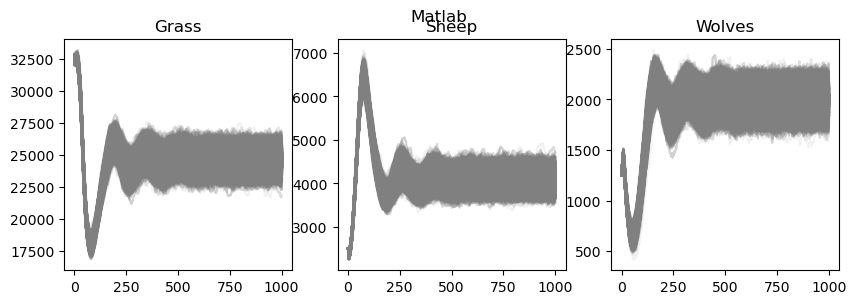

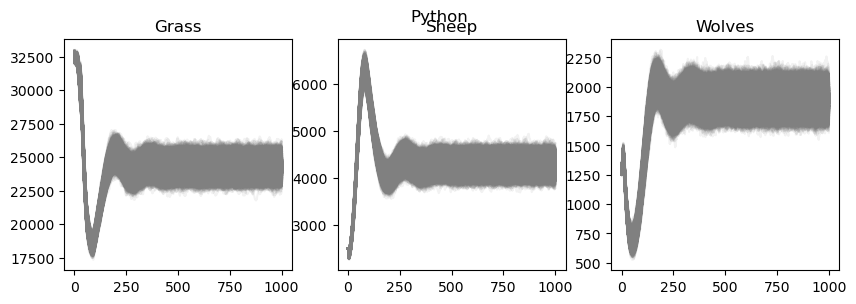

In [3]:
def plot_loaded_data(_results_time, _data):
    _fig, _ax = plt.subplots(1, 3, figsize=(10, 3))
    for i, p in enumerate(prefices):
        p_data = _data[p]
        for repl_num in range(p_data.shape[0]):
            _ax[i].plot(_results_time, p_data[repl_num, :], alpha=0.1, color='gray')
        _ax[i].set_title(p)
    return _fig, _ax


fig, ax = plot_loaded_data(results_time, data_nl)
fig.suptitle('Netlogo')

fig, ax = plot_loaded_data(results_time, data_ml)
fig.suptitle('Matlab')

fig, ax = plot_loaded_data(results_time, data_py)
_ = fig.suptitle('Python')

In [4]:
# Runtime: 2151 min (Precision laptop)
import ipywidgets as ipw
from IPython.display import display
out = ipw.Output()
display(out)


def analyze_data(_size_test, _data):
    _kss_size = {sz: (0.0, 0.0) for sz in _size_test}
    _eval_info_size = {sz: dict() for sz in _size_test}
    _mean_size = {sz: dict() for sz in _size_test}
    _std_size = {sz: dict() for sz in _size_test}
    
    _idx_best_fit = {sz: -1 for sz in _size_test}
    _idx_worst_fit = {sz: -1 for sz in _size_test}
    _idx_biggest_window = {sz: -1 for sz in _size_test}
    _idx_smallest_window = {sz: -1 for sz in _size_test}

    for sz in _size_test:
        _subsample = {k: v[:sz, :] for k, v in _data.items()}
        with out:
            out.append_stdout(f'Sample size: {sz}\n')
        ks_stats_sampling = sim_lib.test_sampling(_subsample, err_thresh=1E-3, out=out, num_workers=num_workers)[0]
        _kss_size[sz] = np.average(ks_stats_sampling), np.std(ks_stats_sampling)
        
        _, _kss_ind, _eval_info_size[sz] = sim_lib.find_ecfs(_subsample)
        _ks_stat_all = [[v[i] for v in _kss_ind.values()] for i in range(len(list(_kss_ind.values())[0]))]
        _ks_stat_all_min = [min(v) for v in _ks_stat_all]
        _ks_stat_all_max = [max(v) for v in _ks_stat_all]
        
        _idx_best_fit[sz] = _ks_stat_all_min.index(min(_ks_stat_all_min))
        _idx_worst_fit[sz] = _ks_stat_all_max.index(max(_ks_stat_all_max))
        
        _fin_size_all = [[v[i][1] for v in _eval_info_size[sz].values()] for i in range(len(list(_eval_info_size[sz].values())[0]))]
        _fin_size_all_min = [min(v) for v in _fin_size_all]
        _fin_size_all_max = [max(v) for v in _fin_size_all]
        
        _idx_biggest_window[sz] = _fin_size_all_max.index(max(_fin_size_all_max))
        _idx_smallest_window[sz] = _fin_size_all_min.index(min(_fin_size_all_min))
        
        for k, v in _data.items():
            _subsample = v[:sz, :]
            _mean_size[sz][k] = np.average(_subsample, 0)
            _std_size[sz][k] = np.std(_subsample, 0)

    return _kss_size, _eval_info_size, _mean_size, _std_size, _idx_best_fit, _idx_worst_fit, _idx_biggest_window, _idx_smallest_window


out.append_stdout('Analyzing Netlogo results...\n')
kss_size_nl, eval_info_size_nl, mean_size_nl, std_size_nl, idx_best_fit_nl, idx_worst_fit_nl, idx_biggest_window_nl, idx_smallest_window_nl = analyze_data(size_test, data_nl)
out.append_stdout('Analyzing Matlab results...\n')
kss_size_ml, eval_info_size_ml, mean_size_ml, std_size_ml, idx_best_fit_ml, idx_worst_fit_ml, idx_biggest_window_ml, idx_smallest_window_ml = analyze_data(size_test, data_ml)
out.append_stdout('Analyzing Python results...\n')
kss_size_py, eval_info_size_py, mean_size_py, std_size_py, idx_best_fit_py, idx_worst_fit_py, idx_biggest_window_py, idx_smallest_window_py = analyze_data(size_test, data_py)

Output()

In [14]:
import json
import os

# Hack algorithm into library
sim_lib.known_sim_algs.append('GSW')

# Save data (for all tested sample sizes, just in case)

def save_metadata(_fp: str, _sz: int, _data, _kss_size):
    exp_sample_size = int(_sz/2)
    exp_ecf_eval, _, exp_ecf_eval_info = sim_lib.find_ecfs({n: v[:exp_sample_size] for n, v in _data.items()})
    exp_ks_stat_mean = _kss_size[_sz][0]
    exp_ks_stat_stdev = _kss_size[_sz][1]
    exp_metadata = sim_lib.Metadata(sample_size=exp_sample_size,
                                    simulator='GSW',
                                    ks_stat_mean=exp_ks_stat_mean,
                                    ks_stat_stdev=exp_ks_stat_stdev,
                                    sample_times=results_time,
                                    ecf_evals=exp_ecf_eval,
                                    ecf_eval_info=exp_ecf_eval_info)
    with open(_fp, 'w') as f:
        json.dump(exp_metadata.to_json(), f, indent=4)


output_dir = res_dir + '/results'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)


for sz in size_test:
    print('Saving metadata for sample size', sz)
    save_metadata(output_dir + f'/gsw_nl_{sz}.json', sz, data_nl, kss_size_nl)
    save_metadata(output_dir + f'/gsw_ml_{sz}.json', sz, data_ml, kss_size_ml)
    save_metadata(output_dir + f'/gsw_py_{sz}.json', sz, data_py, kss_size_py)

Saving metadata for sample size 100
Saving metadata for sample size 500
Saving metadata for sample size 1000
Saving metadata for sample size 5000
Saving metadata for sample size 10000
Saving metadata for sample size 15000
Saving metadata for sample size 20000


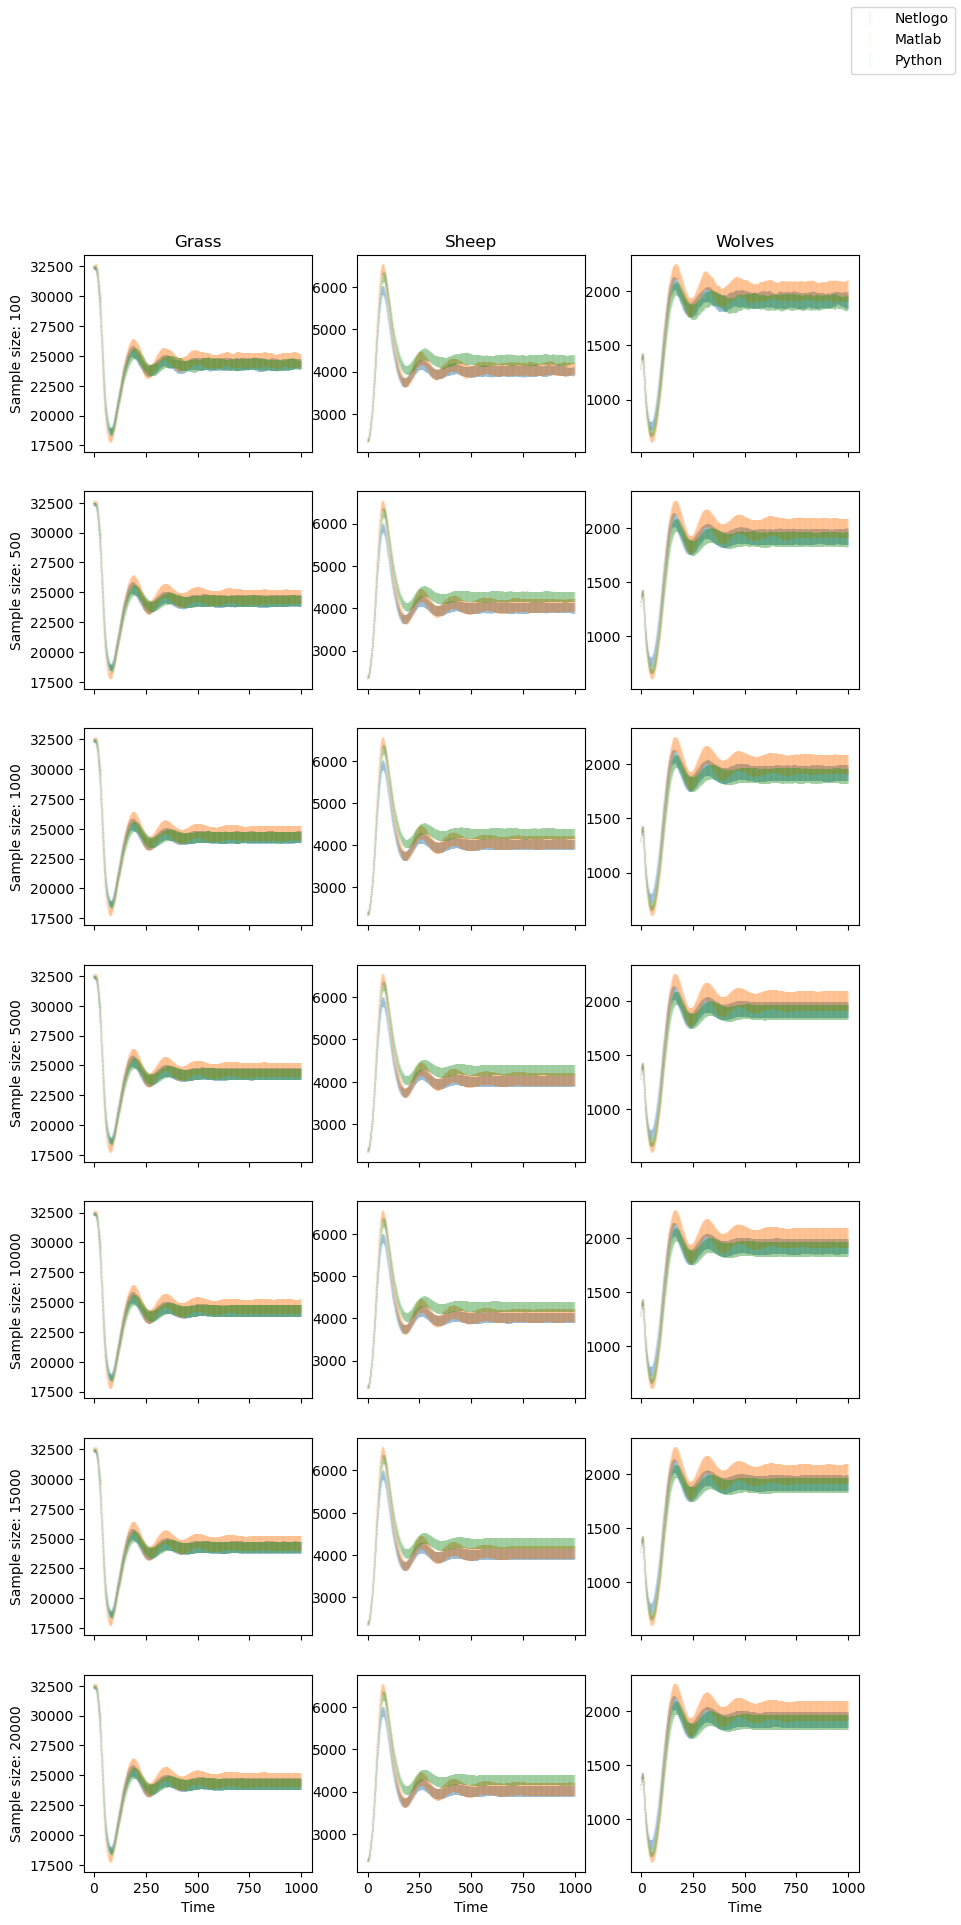

In [5]:
def plot_experiment_stat(_size_test, _results_time, _data_mean, _data_std, _label: str, _fig_ax=None):
    if _fig_ax:
        fig, ax = _fig_ax
    else:
        fig, ax = plt.subplots(len(_size_test), 3, figsize=(10, 3*len(_size_test)), sharex=True)

    for i, sz in enumerate(_size_test):
        for j, p in enumerate(prefices):
            ax_ij = ax[i][j]
            ax_ij.errorbar(_results_time, _data_mean[sz][p].T, yerr=_data_std[sz][p].T, marker='', linestyle='None', alpha=0.05, label=_label)
            
            if i == 0:
                ax_ij.set_title(p)
            elif i == len(_size_test) - 1:
                ax_ij.set_xlabel('Time')
            if j == 0:
                ax_ij.set_ylabel(f'Sample size: {sz}')
    return fig, ax


fig, ax = plot_experiment_stat(size_test, results_time, mean_size_nl, std_size_nl, 'Netlogo')
plot_experiment_stat(size_test, results_time, mean_size_ml, std_size_ml, 'Matlab', (fig, ax))
plot_experiment_stat(size_test, results_time, mean_size_py, std_size_py, 'Python', (fig, ax))
_ = fig.legend(['Netlogo', 'Matlab', 'Python'])

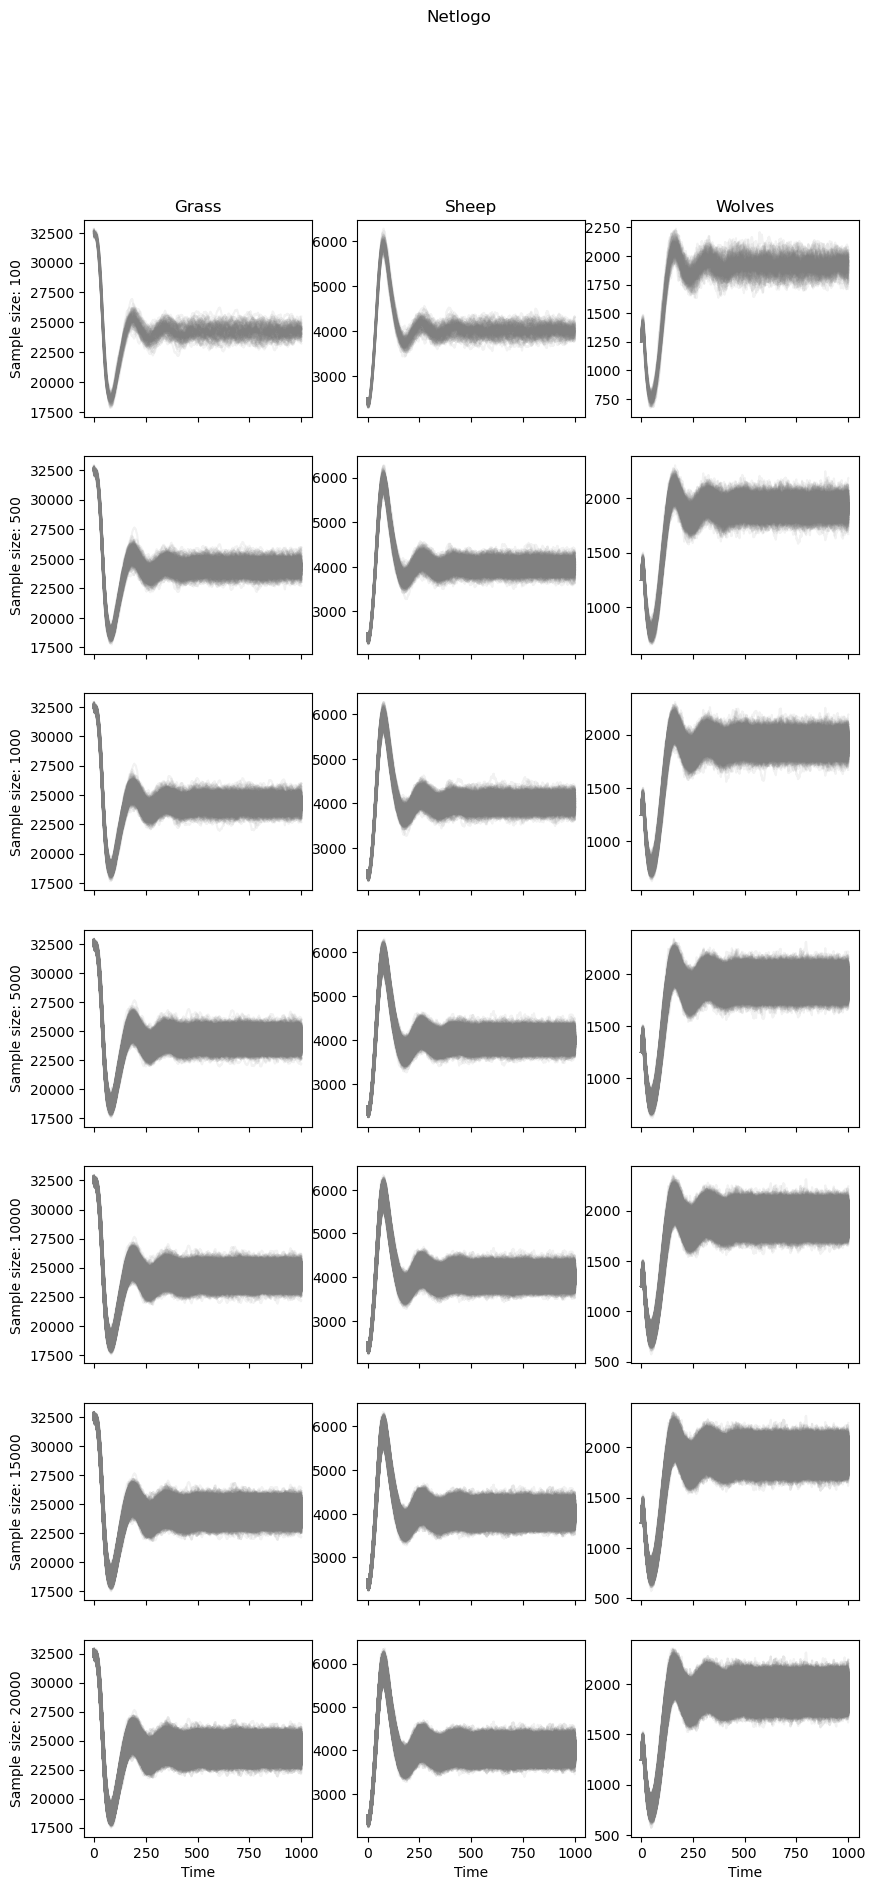

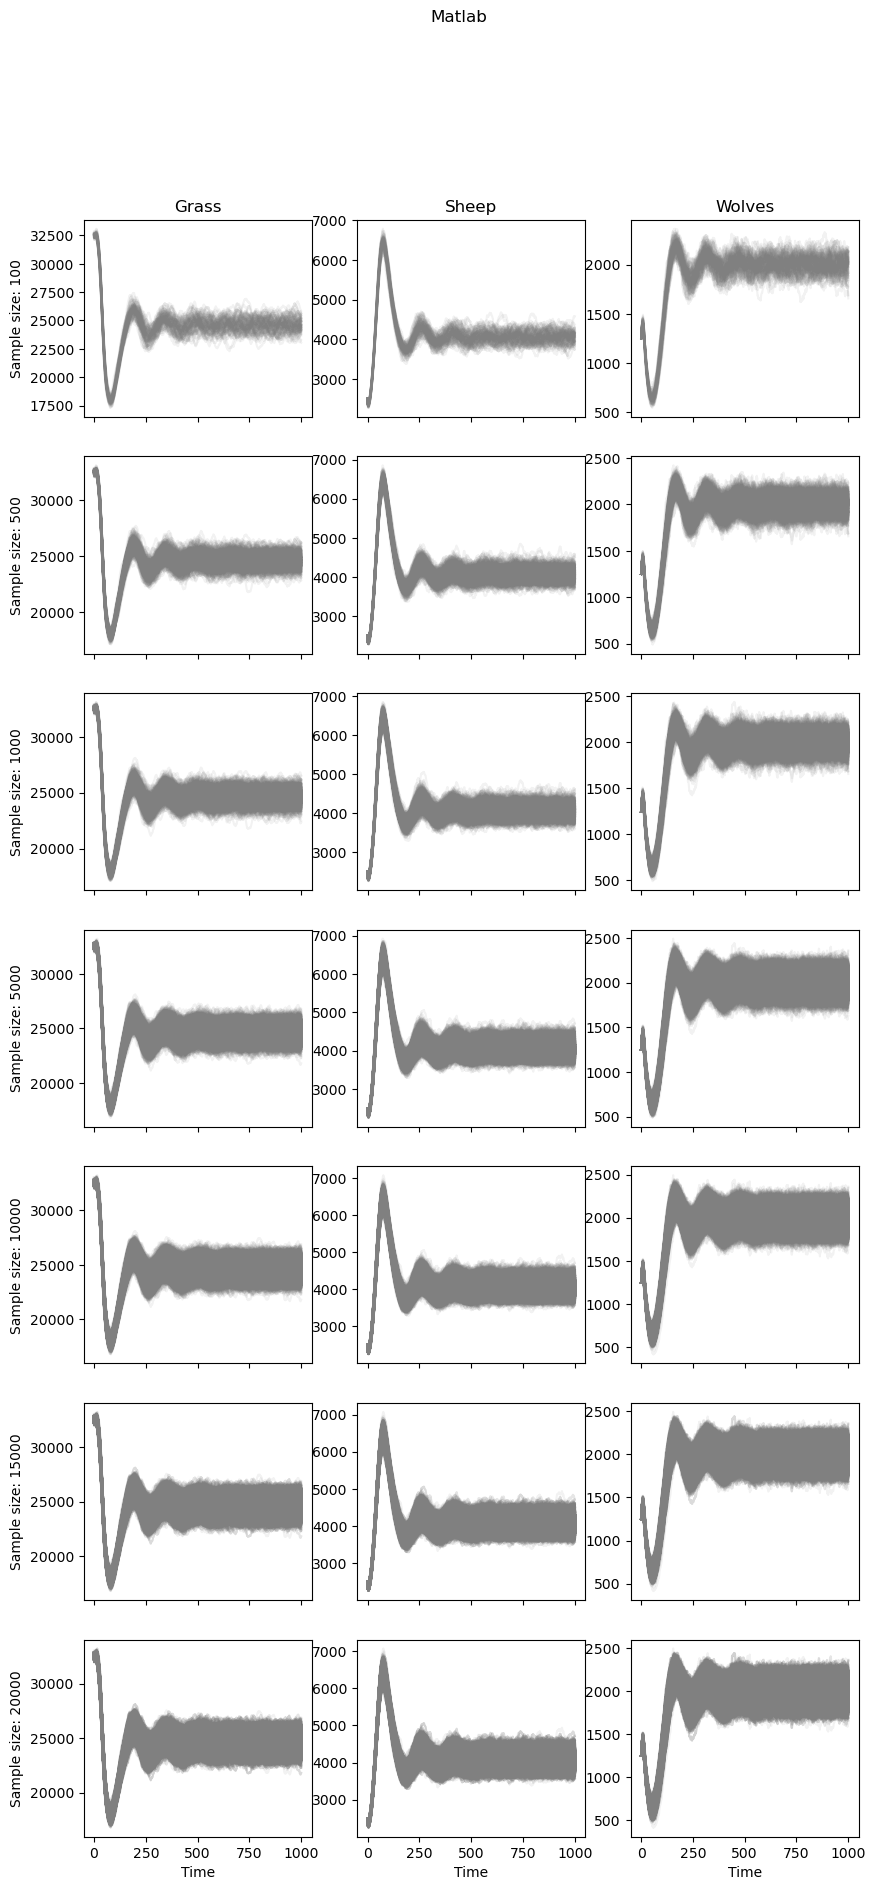

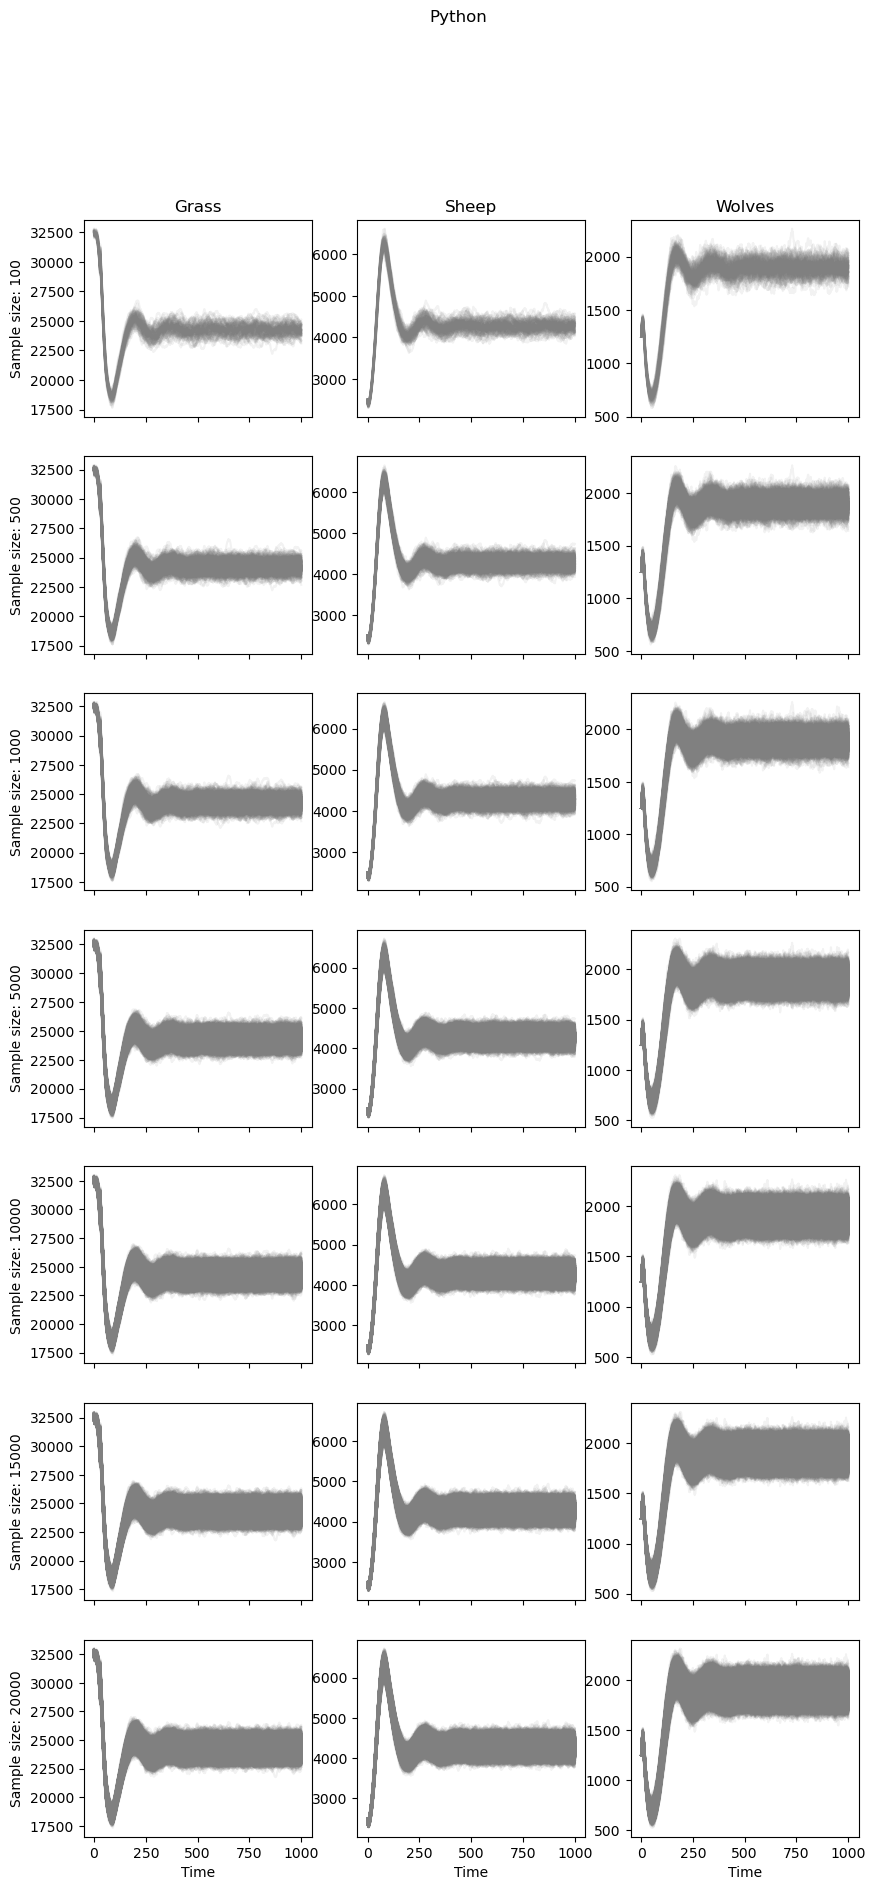

In [6]:
def plot_experiment_samples(_size_test, _results_time, _data):

    fig, ax = plt.subplots(len(_size_test), 3, figsize=(10, 3*len(_size_test)), sharex=True)

    for i, sz in enumerate(_size_test):
        sz_results_time = np.zeros((_results_time.shape[0], sz))
        for j in range(sz):
            sz_results_time[:, j] = _results_time
        for j, p in enumerate(prefices):
            ax_ij = ax[i][j]
            ax_ij.plot(sz_results_time, _data[p][:sz, :].T, alpha=0.1, color='gray')
            
            if i == 0:
                ax_ij.set_title(p)
            elif i == len(_size_test) - 1:
                ax_ij.set_xlabel('Time')
            if j == 0:
                ax_ij.set_ylabel(f'Sample size: {sz}')
    
    return fig, ax


fig, ax = plot_experiment_samples(size_test, results_time, data_nl)
fig.suptitle('Netlogo')
fig, ax = plot_experiment_samples(size_test, results_time, data_ml)
fig.suptitle('Matlab')
fig, ax = plot_experiment_samples(size_test, results_time, data_py)
_ = fig.suptitle('Python')

Size Netlogo Matlab Python
100 (0.6991358193534208, 0.034351433241639466) (0.6961918787652803, 0.039211553998523864) (0.6963183257981588, 0.03250125852970694)
500 (0.3150425170720867, 0.01585673521232317) (0.31476671278244345, 0.015875105011268043) (0.3159309587438375, 0.016481558729471504)
1000 (0.2225298264357113, 0.01150114475183459) (0.2233275886643509, 0.011423052856752325) (0.22329692671092266, 0.011353119179059323)
5000 (0.10024671284689464, 0.0051681224131792085) (0.10001024285661686, 0.005211397283587157) (0.10025464566012426, 0.005285246659176994)
10000 (0.0705932541187695, 0.003443369412069689) (0.07052977716847263, 0.0036122688587391927) (0.07067360383429207, 0.003754538931067758)
15000 (0.057555400511016416, 0.0029122442755255395) (0.05753238834247472, 0.0029982505255617977) (0.05768102608262723, 0.002799213100783877)
20000 (0.049929092053707505, 0.0025020472079092964) (0.049948829447395676, 0.0025877211280548864) (0.04991148363200453, 0.00242921801029781)


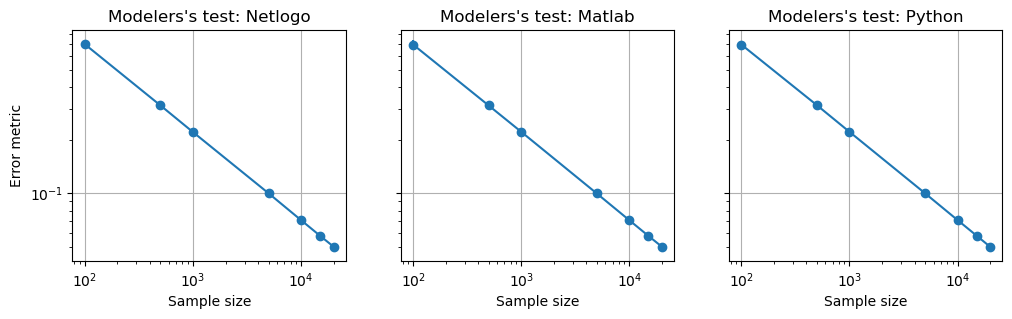

In [7]:
def plot_experiment_ks(_size_test, _kss_size, fig_ax=None):

    if fig_ax is None:
        _fig, _ax = plt.subplots(1, 1, figsize=(6, 6))
    else:
        _fig, _ax = fig_ax

    ks_avg = [_kss_size[s][0] for s in _size_test]
    ks_std = [_kss_size[s][1] for s in _size_test]
    _ax.errorbar(_size_test, ks_avg, yerr=ks_std, marker='o')
    _ax.set_xscale('log')
    _ax.set_yscale('log')
    _ax.grid(True)
    _ax.set_xlabel('Sample size')
    if fig_ax is None:
        _ax.set_ylabel('Error metric')
    
    return _fig, _ax


fig, ax = plt.subplots(1, 3, figsize=(12.0, 3.0), sharey=True)

plot_experiment_ks(size_test, kss_size_nl, (fig, ax[0]))
ax[0].set_title('Modelers\'s test: Netlogo')
ax[0].set_ylabel('Error metric')
plot_experiment_ks(size_test, kss_size_ml, (fig, ax[1]))
ax[1].set_title('Modelers\'s test: Matlab')
plot_experiment_ks(size_test, kss_size_py, (fig, ax[2]))
ax[2].set_title('Modelers\'s test: Python')

_ = ax[0].set_ylabel('Error metric')

names_data = [('Netlogo', kss_size_nl), ('Matlab', kss_size_ml), ('Python', kss_size_py)]
print(' '.join(['Size'] + [d[0] for d in names_data]))
for sz in size_test:
    s = str(sz)
    for nd in names_data:
        s += f' {nd[1][sz]}'
    print(s)

In [8]:
print('Comparing experiments: Netlogo vs. Matlab...')
kss_nl_ml = gsw_lib.compare_experiment_implementations(prefices, data_nl, data_ml, eval_info_size_nl, eval_info_size_ml, pool=sim_lib.get_pool())
print('Comparing experiments: Netlogo vs. Python...')
kss_nl_py = gsw_lib.compare_experiment_implementations(prefices, data_nl, data_py, eval_info_size_nl, eval_info_size_py, pool=sim_lib.get_pool())
print('Comparing experiments: Python vs. Matlab...')
kss_py_ml = gsw_lib.compare_experiment_implementations(prefices, data_py, data_ml, eval_info_size_py, eval_info_size_ml, pool=sim_lib.get_pool())

# Append final result
final_key = 'Final'
for sz in size_test:
    kss_nl_ml[sz][final_key] = max([kss_nl_ml[sz][k] for k in prefices])
    kss_nl_py[sz][final_key] = max([kss_nl_py[sz][k] for k in prefices])
    kss_py_ml[sz][final_key] = max([kss_py_ml[sz][k] for k in prefices])

Comparing experiments: Netlogo vs. Matlab...
Comparing experiments: Netlogo vs. Python...
Comparing experiments: Python vs. Matlab...


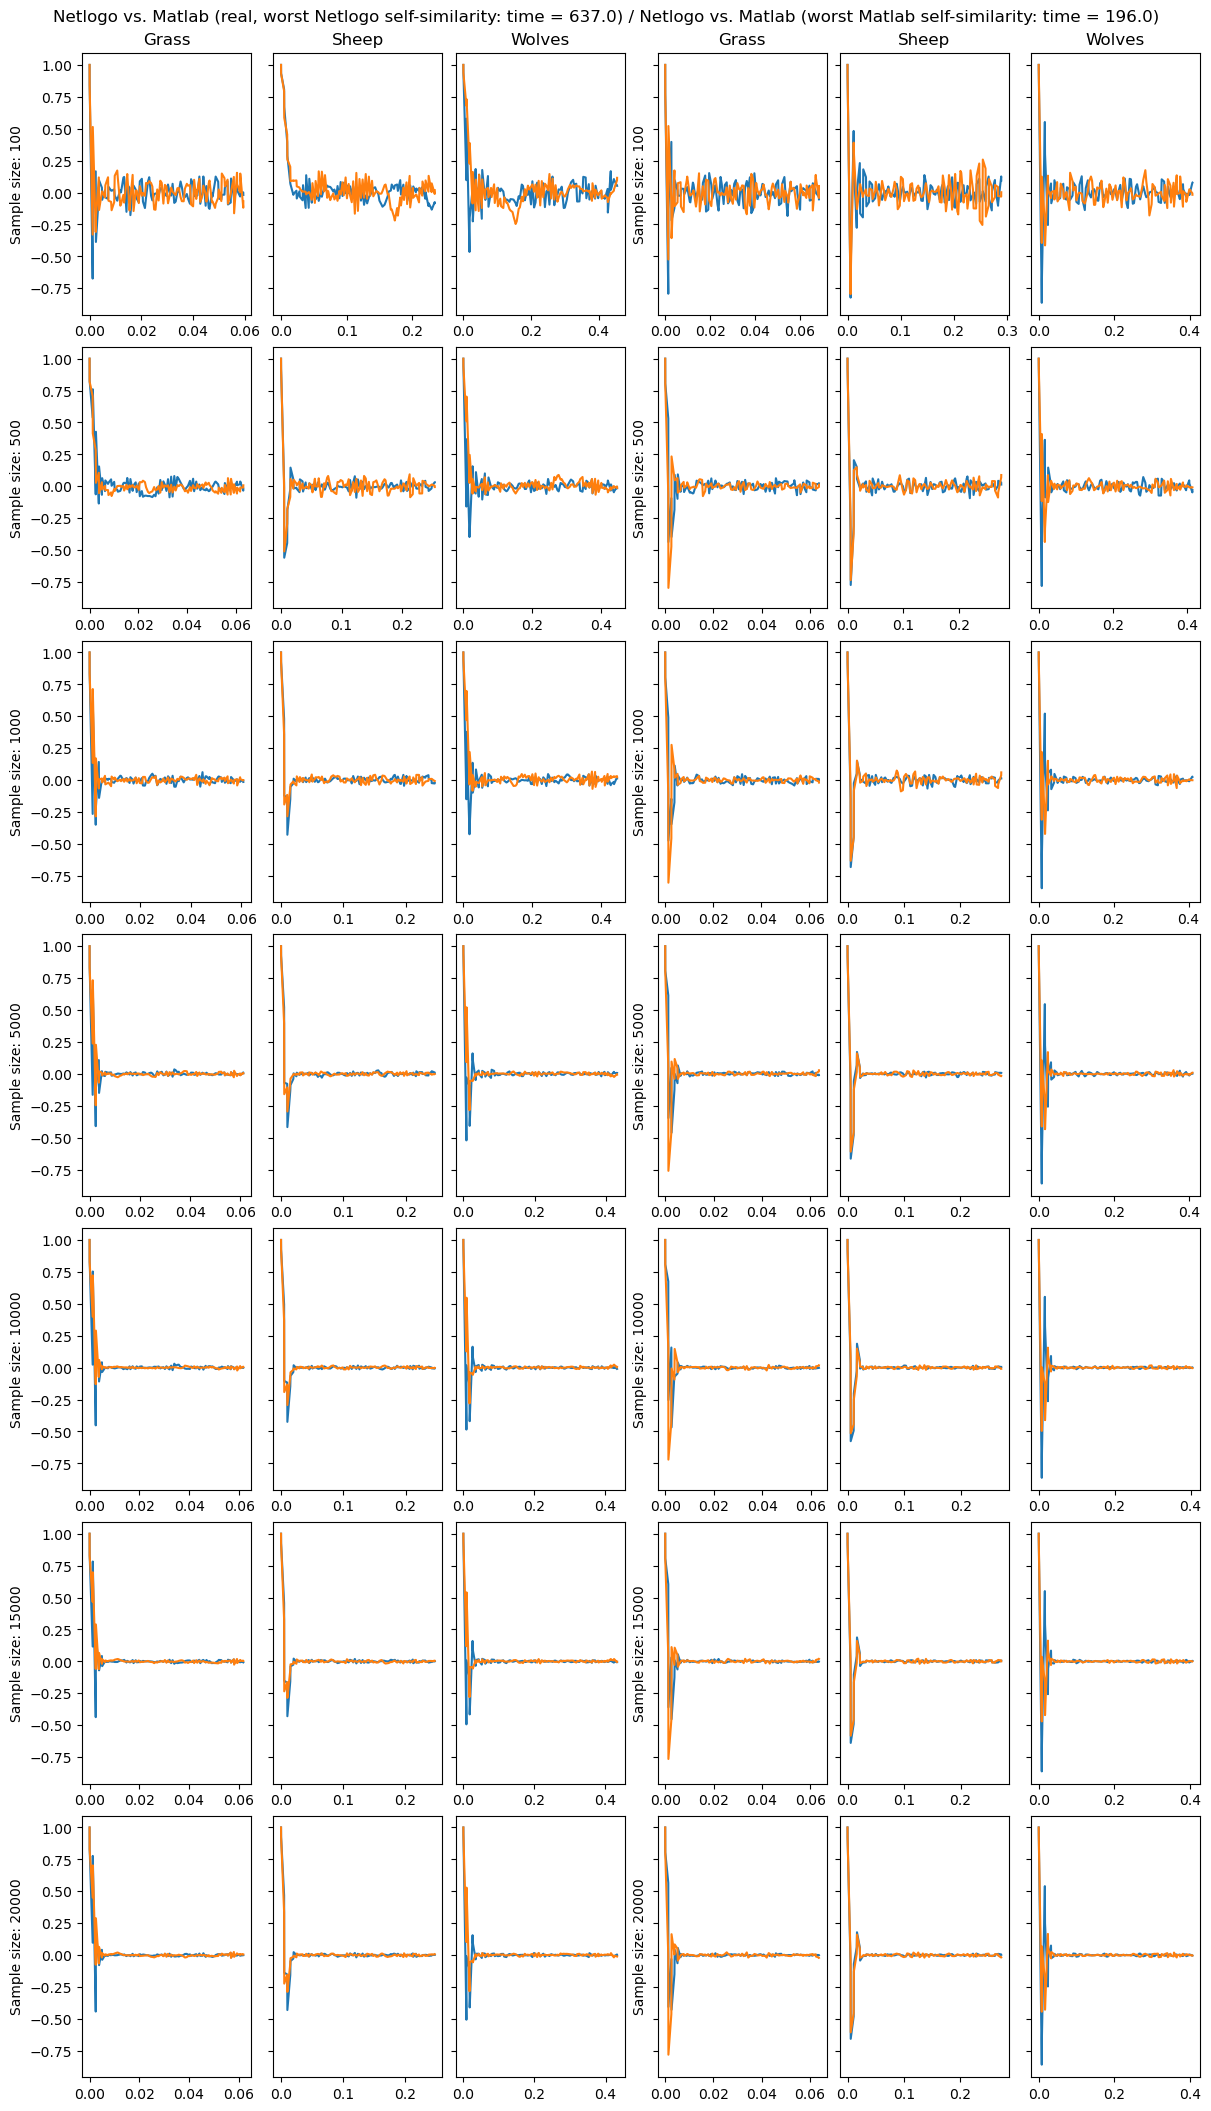

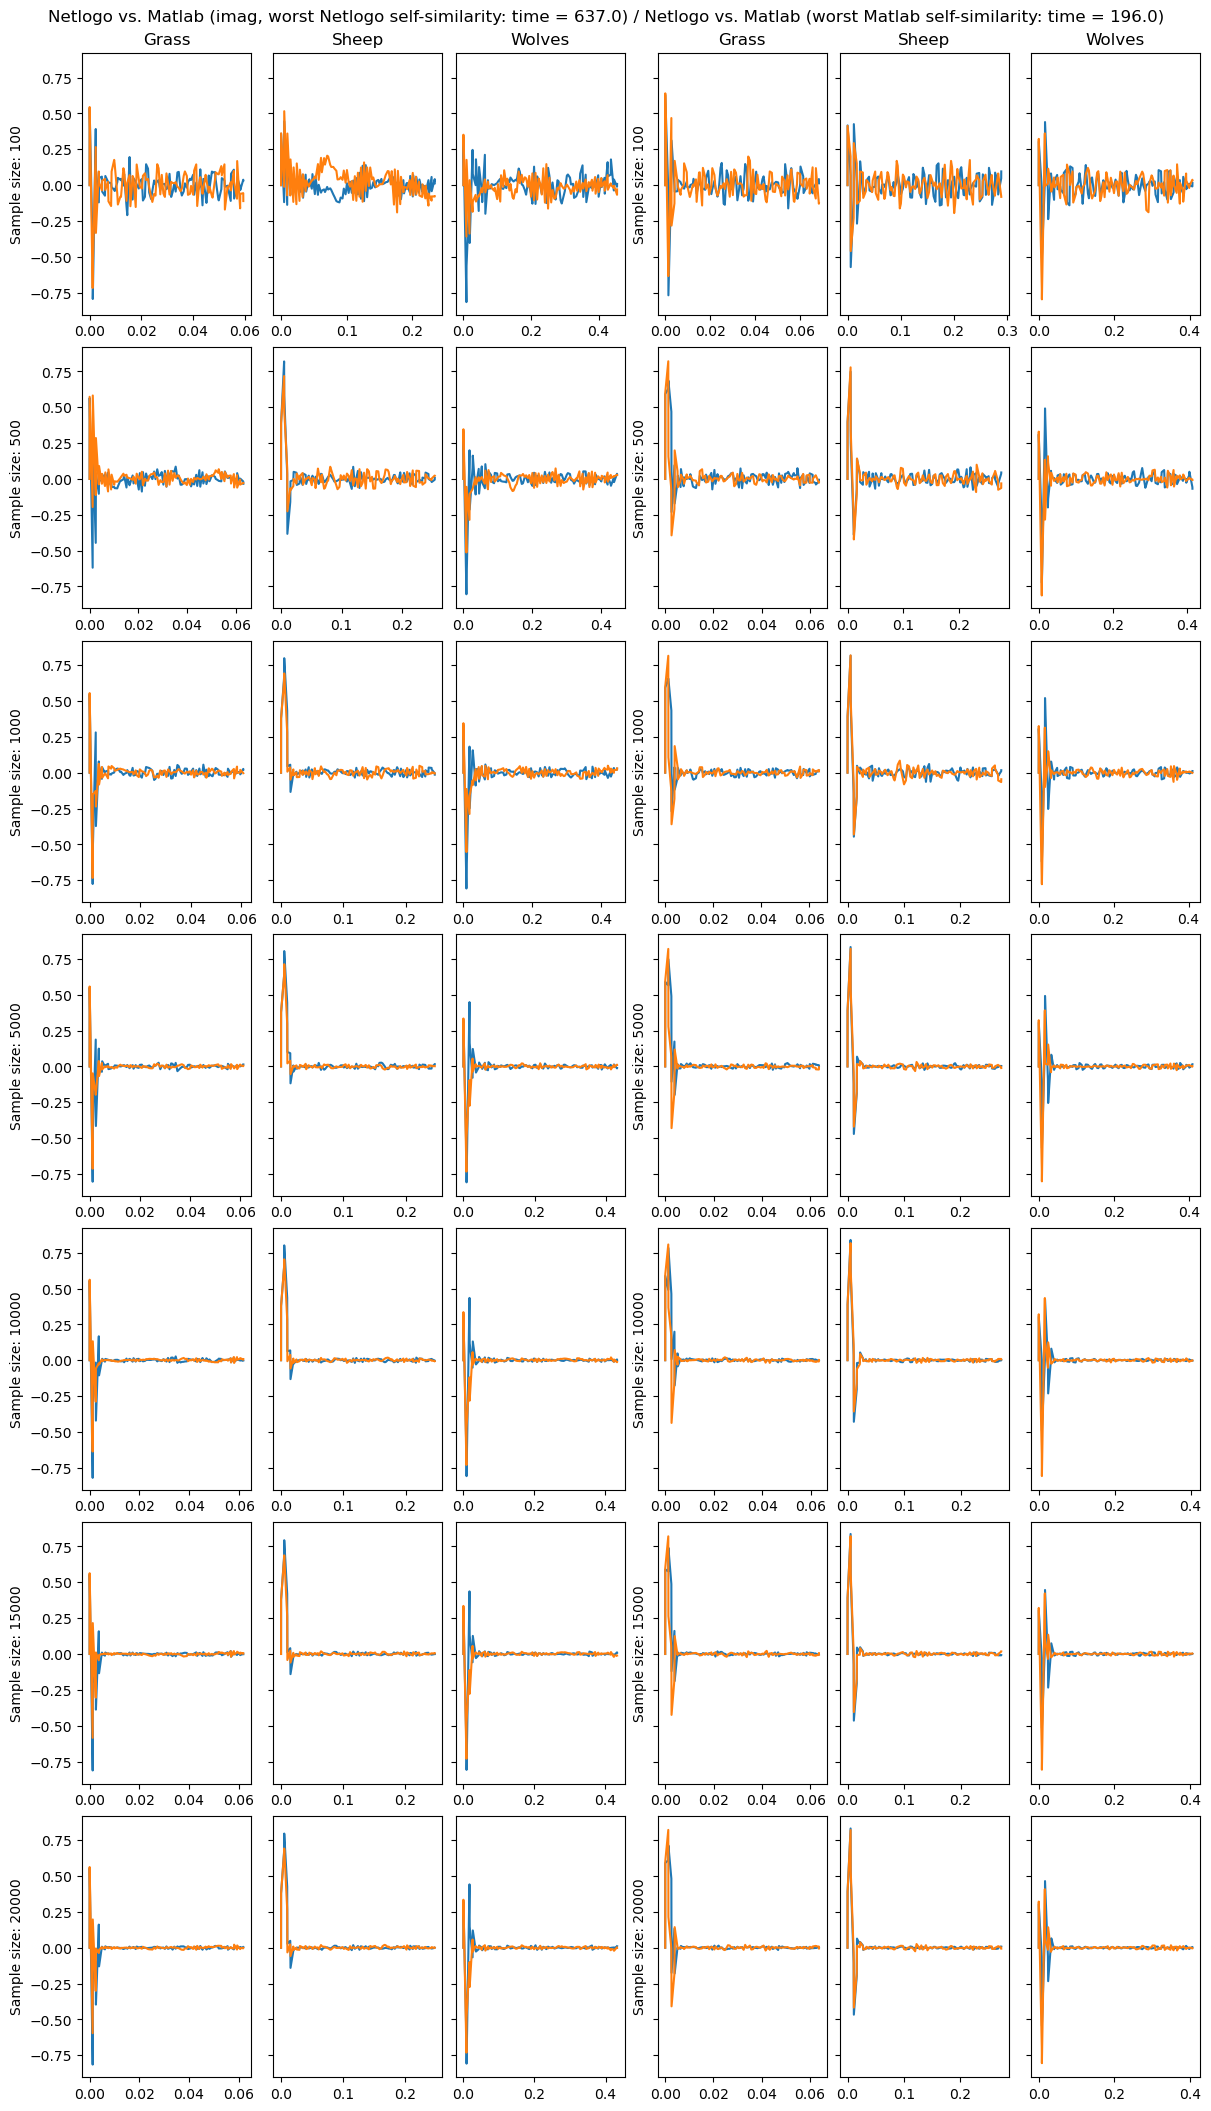

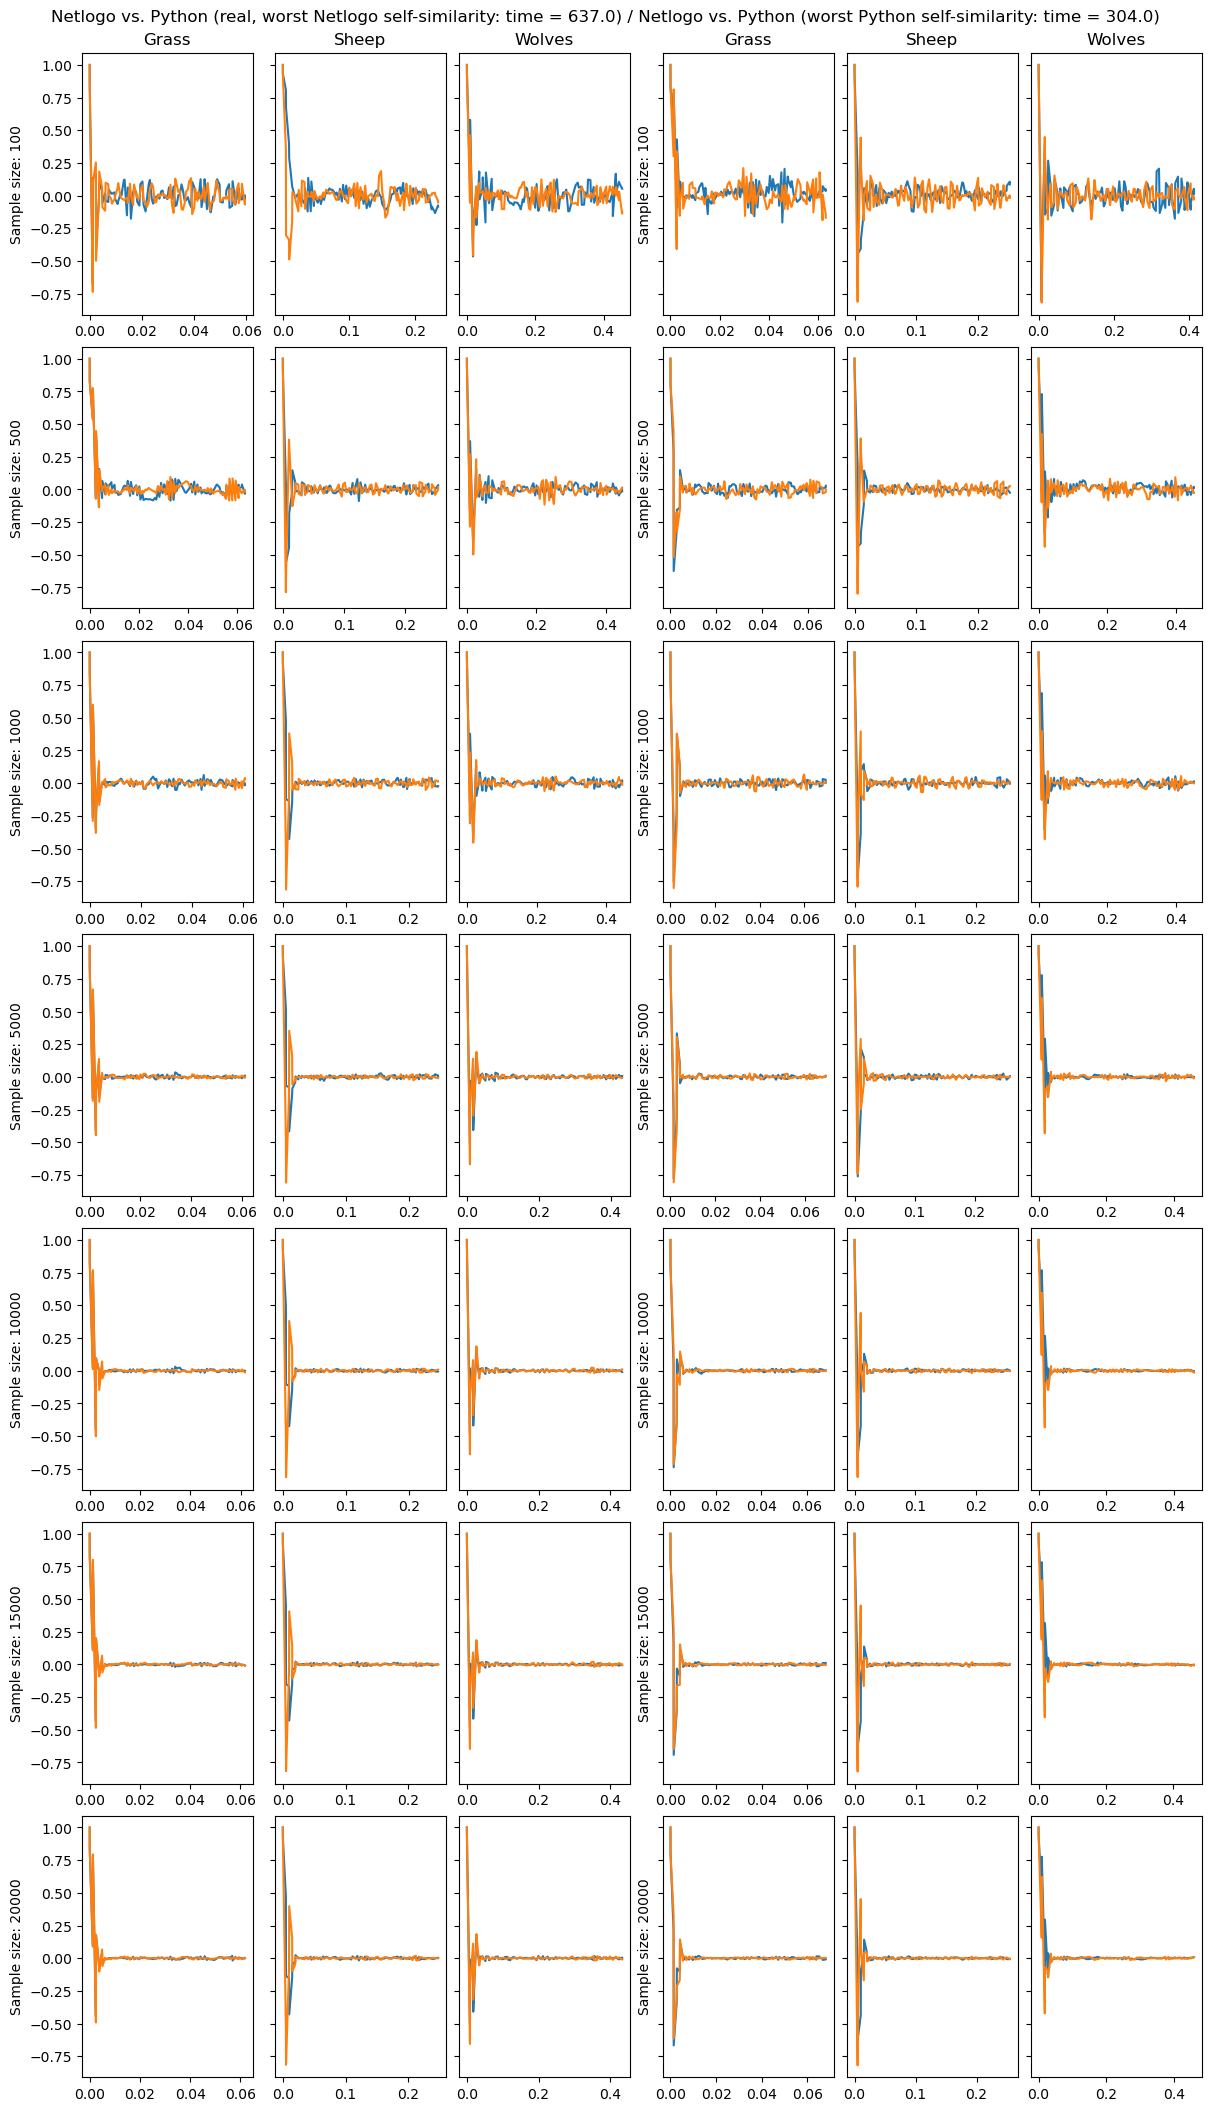

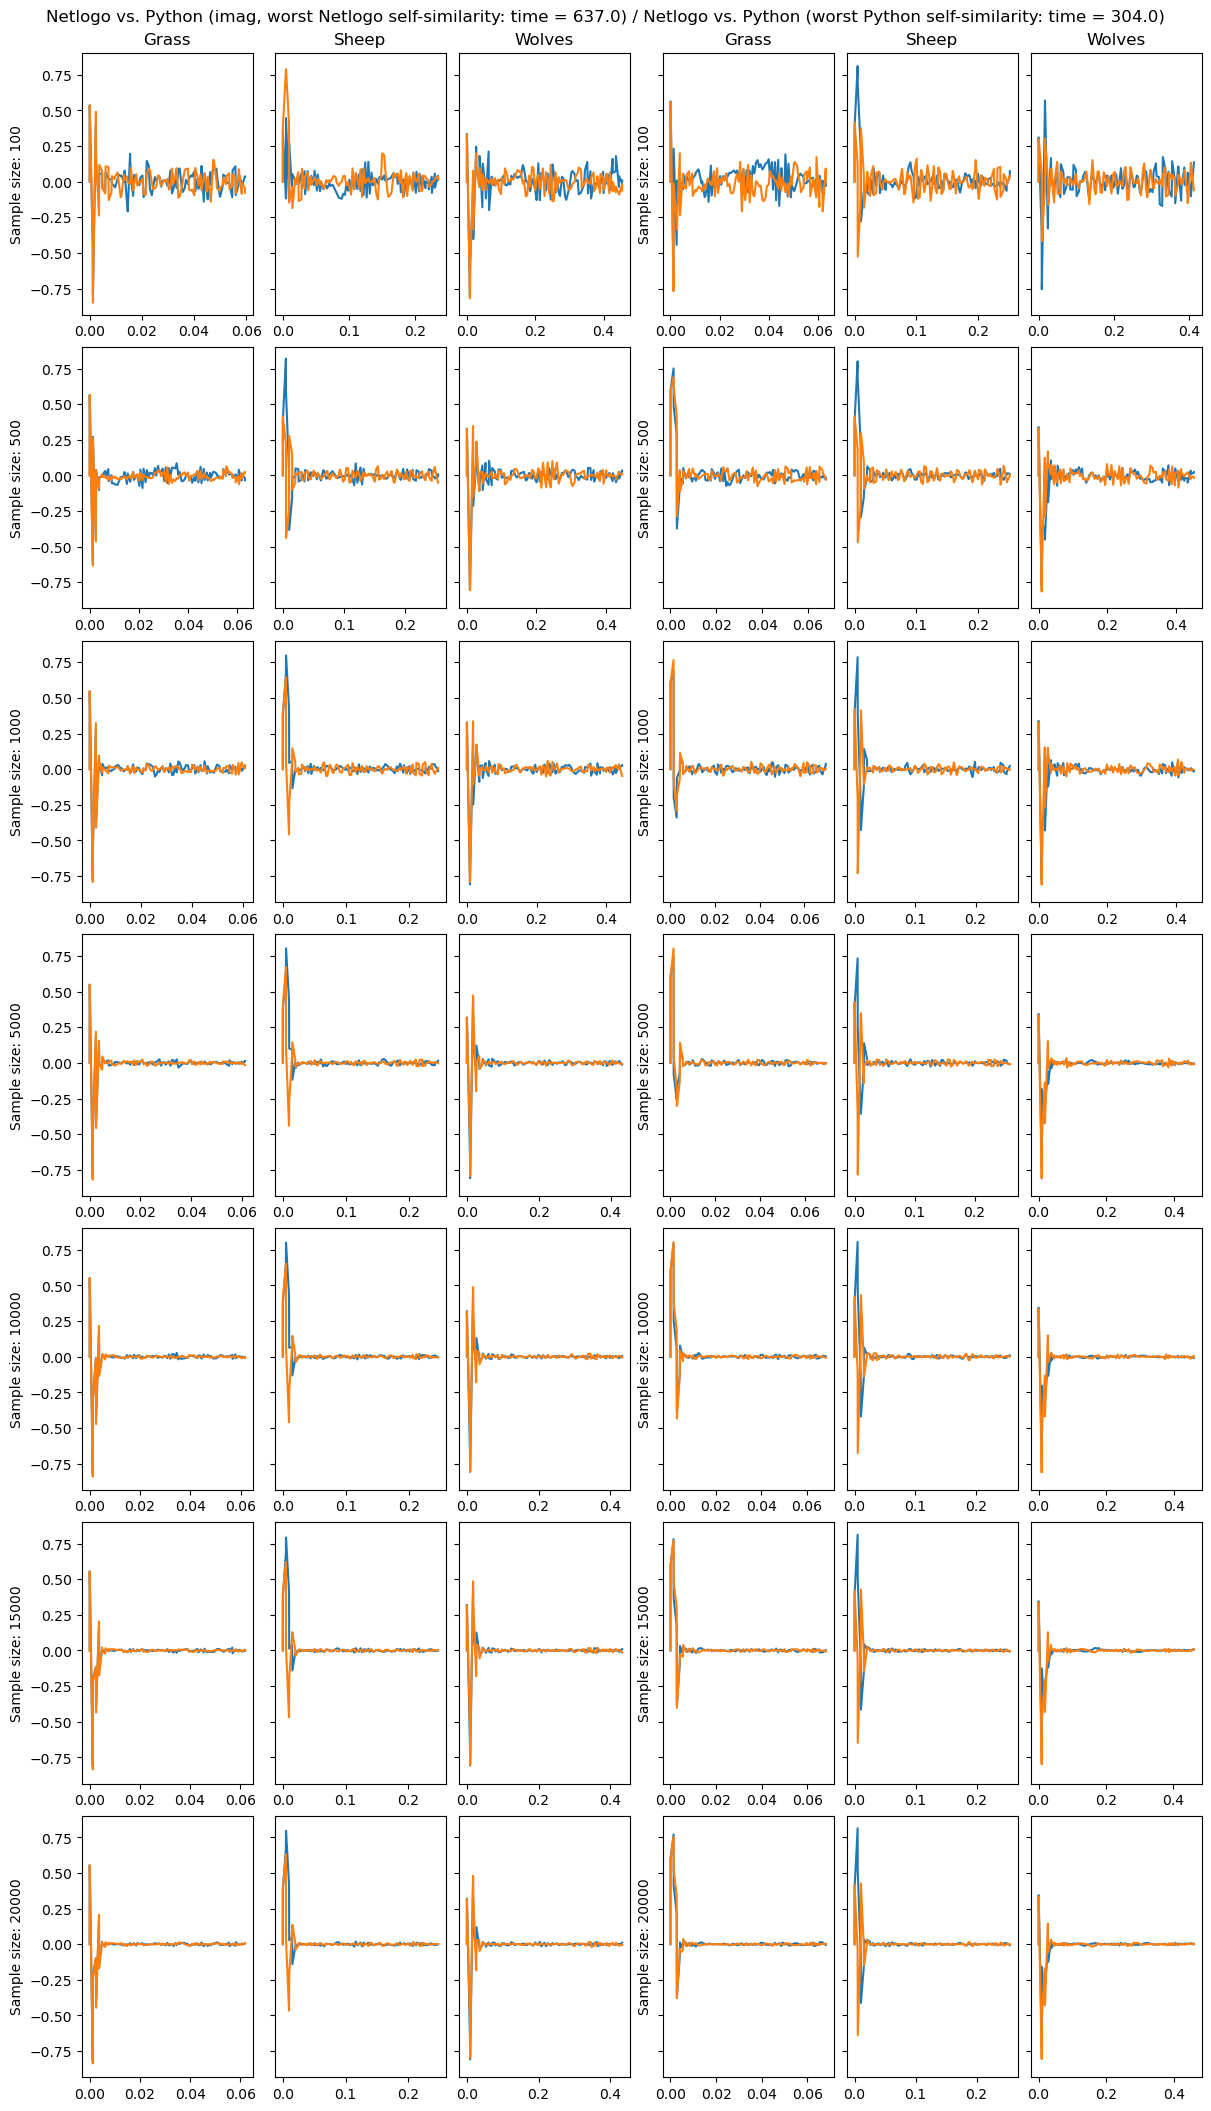

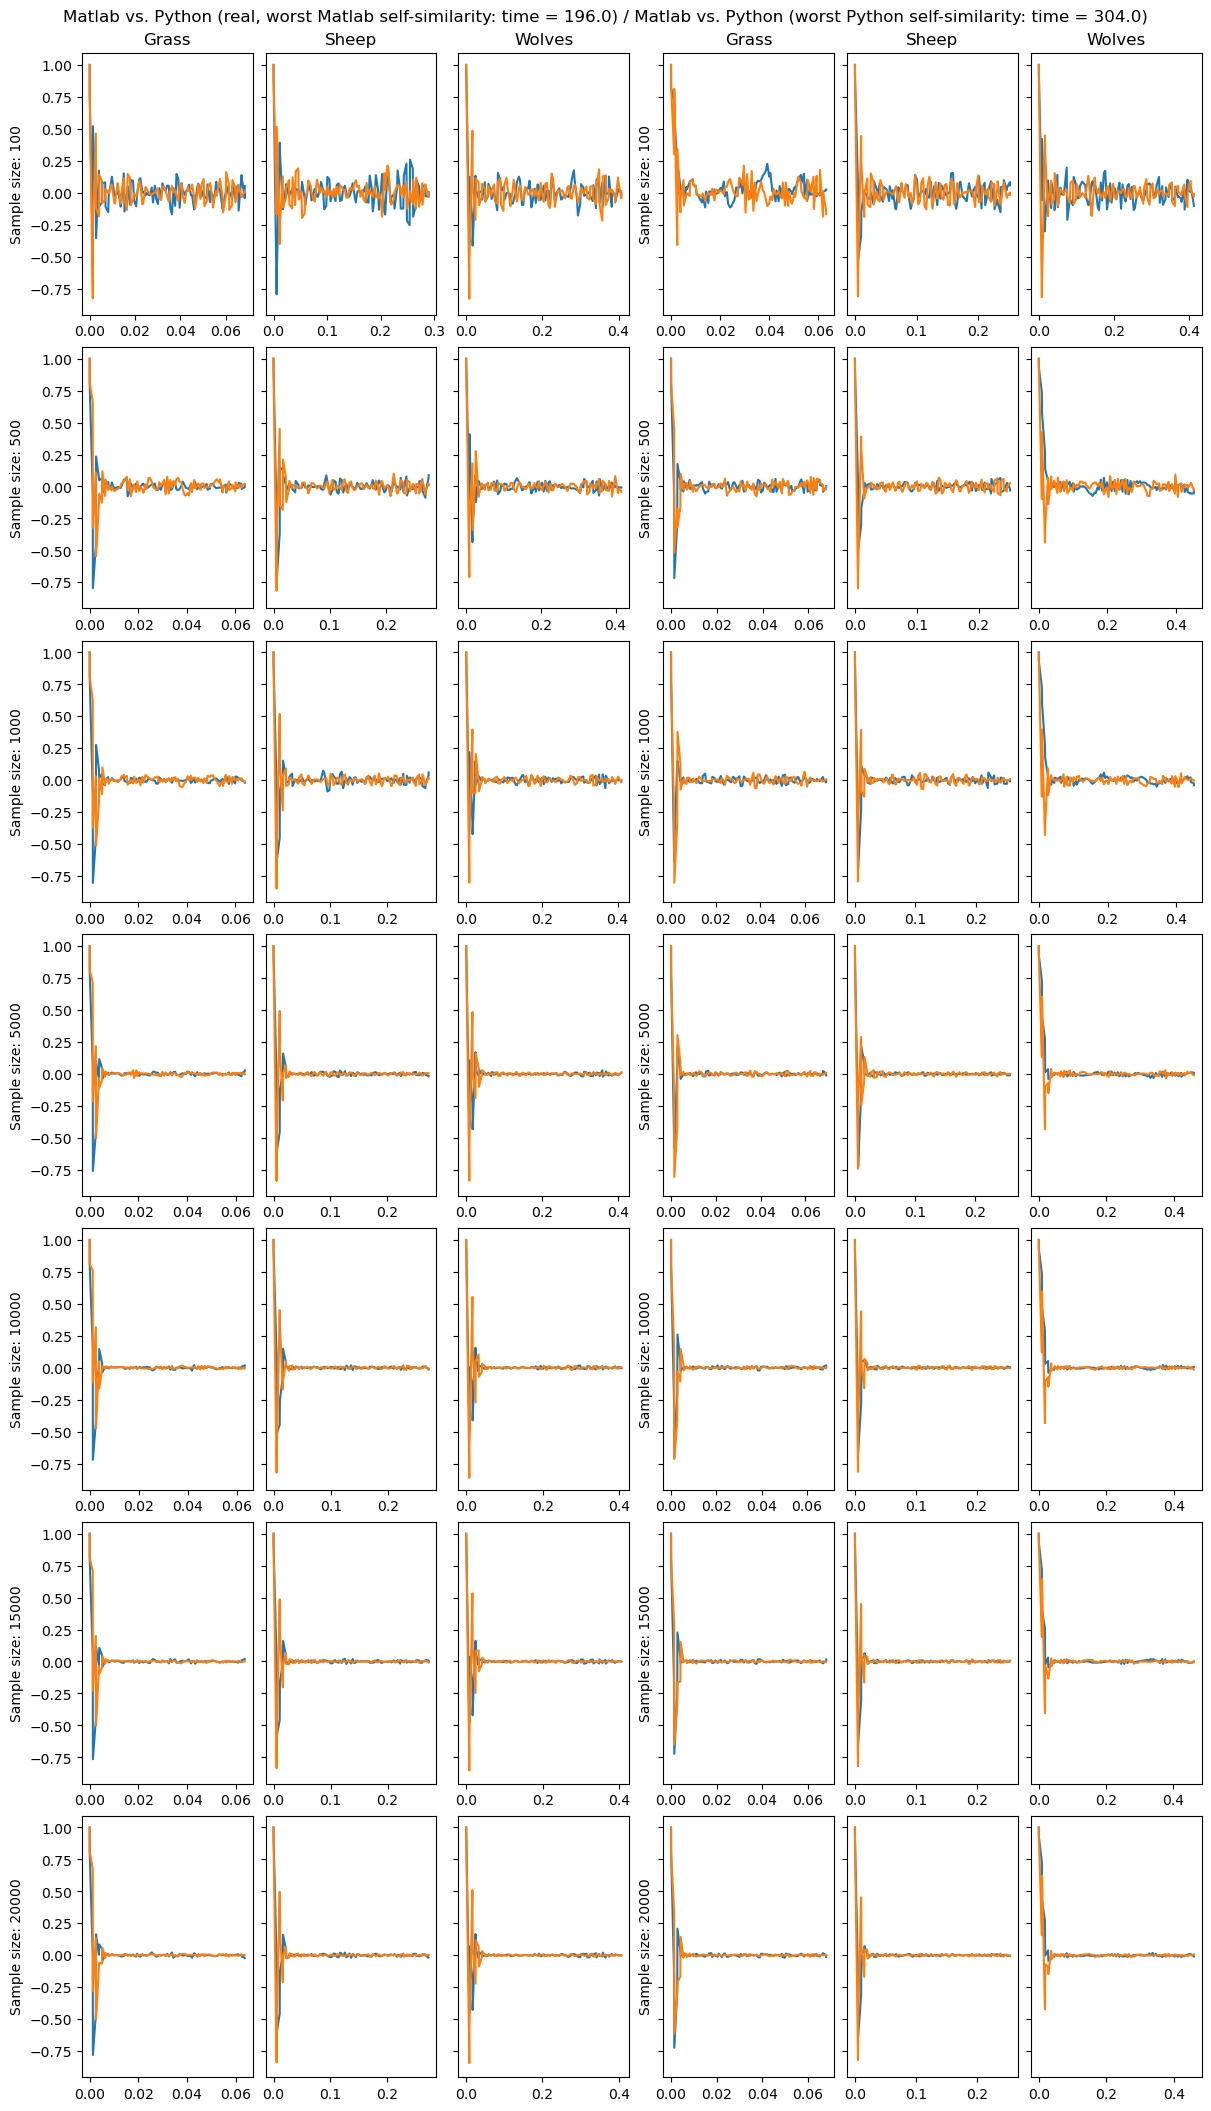

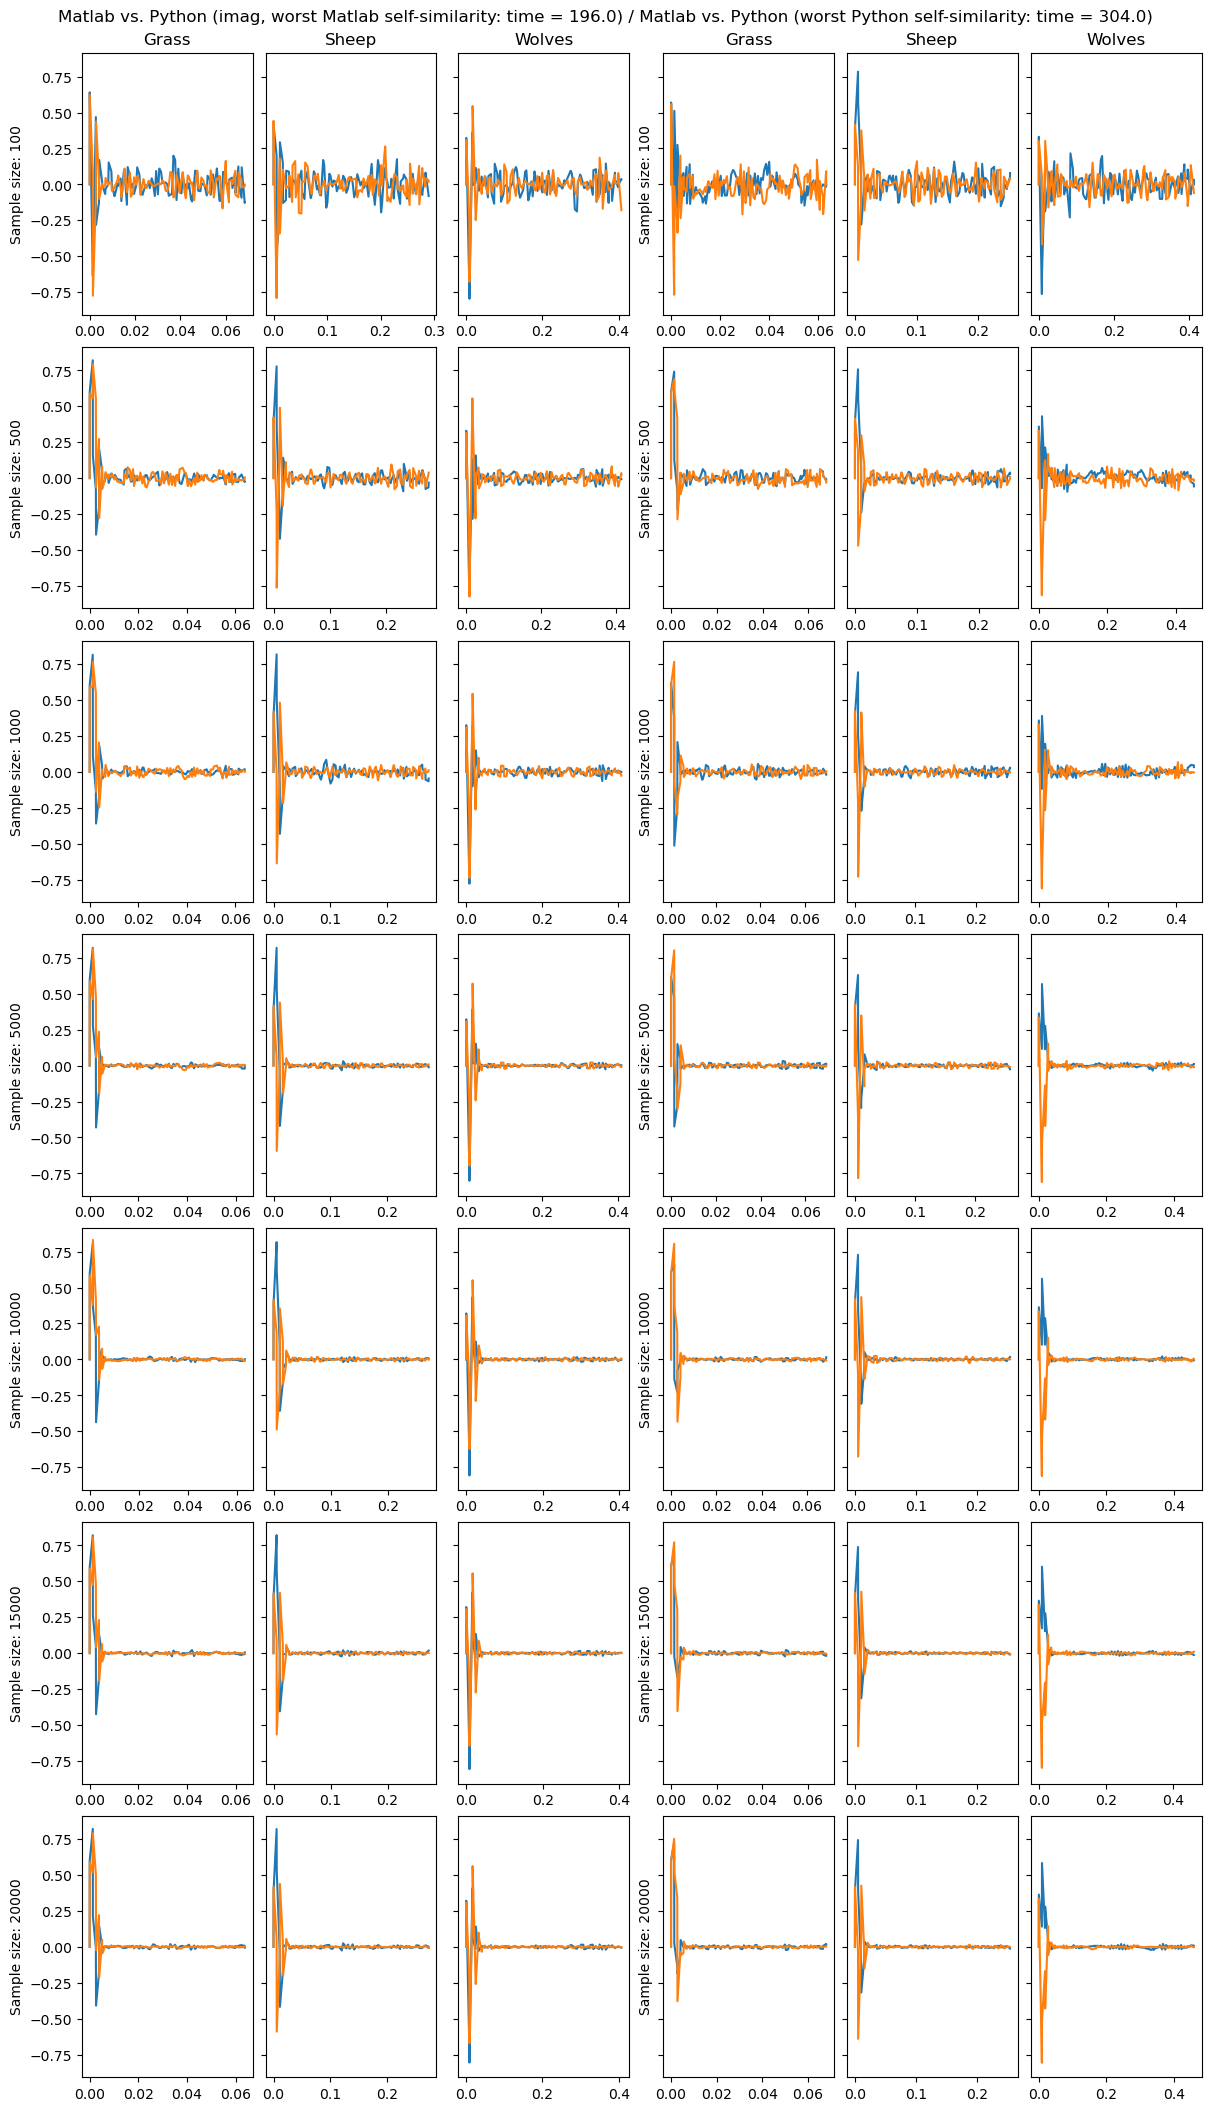

In [9]:
def plot_compare_ecfs(_size_test, _time_idx, _data_impl1, _data_impl2, _eval_info, real_comp: bool, fig_ax=None):
    if fig_ax is None:
        fig, ax = plt.subplots(len(_size_test), 3, figsize=(10, 3*len(_size_test)), sharex=False, sharey=True)
    else:
        fig, ax = fig_ax
    
    idx = 0 if real_comp else 1

    for i, sz in enumerate(_size_test):
        for j, p in enumerate(prefices):
            eval_t = sim_lib.get_eval_info_times(*_eval_info[sz][p][_time_idx])
            ecf_1, ecf_2 = sim_lib.ecf(_data_impl1[p][:sz, _time_idx], eval_t), sim_lib.ecf(_data_impl2[p][:sz, _time_idx], eval_t)
            
            ax_ij = ax[i][j]
            ax_ij.plot(eval_t, ecf_1[:, idx])
            ax_ij.plot(eval_t, ecf_2[:, idx])
            
            if i == 0:
                ax_ij.set_title(p)
            if j == 0:
                ax_ij.set_ylabel(f'Sample size: {sz}')

    return fig, ax

fig, ax = plt.subplots(len(size_test), 6, figsize=(12, 3*len(size_test)), sharey=True, layout='compressed')
plot_compare_ecfs(size_test, idx_worst_fit_nl[size_test[-1]], data_nl, data_ml, eval_info_size_nl, True, (fig, ax[:, :3]))
plot_compare_ecfs(size_test, idx_worst_fit_ml[size_test[-1]], data_nl, data_ml, eval_info_size_ml, True, (fig, ax[:, 3:]))
fig.suptitle(f'Netlogo vs. Matlab (real, worst Netlogo self-similarity: time = {results_time[idx_worst_fit_nl[size_test[-1]]]}) / Netlogo vs. Matlab (worst Matlab self-similarity: time = {results_time[idx_worst_fit_ml[size_test[-1]]]})')

fig, ax = plt.subplots(len(size_test), 6, figsize=(12, 3*len(size_test)), sharey=True, layout='compressed')
plot_compare_ecfs(size_test, idx_worst_fit_nl[size_test[-1]], data_nl, data_ml, eval_info_size_nl, False, (fig, ax[:, :3]))
plot_compare_ecfs(size_test, idx_worst_fit_ml[size_test[-1]], data_nl, data_ml, eval_info_size_ml, False, (fig, ax[:, 3:]))
fig.suptitle(f'Netlogo vs. Matlab (imag, worst Netlogo self-similarity: time = {results_time[idx_worst_fit_nl[size_test[-1]]]}) / Netlogo vs. Matlab (worst Matlab self-similarity: time = {results_time[idx_worst_fit_ml[size_test[-1]]]})')

fig, ax = plt.subplots(len(size_test), 6, figsize=(12, 3*len(size_test)), sharey=True, layout='compressed')
plot_compare_ecfs(size_test, idx_worst_fit_nl[size_test[-1]], data_nl, data_py, eval_info_size_nl, True, (fig, ax[:, :3]))
plot_compare_ecfs(size_test, idx_worst_fit_py[size_test[-1]], data_nl, data_py, eval_info_size_py, True, (fig, ax[:, 3:]))
fig.suptitle(f'Netlogo vs. Python (real, worst Netlogo self-similarity: time = {results_time[idx_worst_fit_nl[size_test[-1]]]}) / Netlogo vs. Python (worst Python self-similarity: time = {results_time[idx_worst_fit_py[size_test[-1]]]})')

fig, ax = plt.subplots(len(size_test), 6, figsize=(12, 3*len(size_test)), sharey=True, layout='compressed')
plot_compare_ecfs(size_test, idx_worst_fit_nl[size_test[-1]], data_nl, data_py, eval_info_size_nl, False, (fig, ax[:, :3]))
plot_compare_ecfs(size_test, idx_worst_fit_py[size_test[-1]], data_nl, data_py, eval_info_size_py, False, (fig, ax[:, 3:]))
fig.suptitle(f'Netlogo vs. Python (imag, worst Netlogo self-similarity: time = {results_time[idx_worst_fit_nl[size_test[-1]]]}) / Netlogo vs. Python (worst Python self-similarity: time = {results_time[idx_worst_fit_py[size_test[-1]]]})')

fig, ax = plt.subplots(len(size_test), 6, figsize=(12, 3*len(size_test)), sharey=True, layout='compressed')
plot_compare_ecfs(size_test, idx_worst_fit_ml[size_test[-1]], data_ml, data_py, eval_info_size_ml, True, (fig, ax[:, :3]))
plot_compare_ecfs(size_test, idx_worst_fit_py[size_test[-1]], data_ml, data_py, eval_info_size_py, True, (fig, ax[:, 3:]))
fig.suptitle(f'Matlab vs. Python (real, worst Matlab self-similarity: time = {results_time[idx_worst_fit_ml[size_test[-1]]]}) / Matlab vs. Python (worst Python self-similarity: time = {results_time[idx_worst_fit_py[size_test[-1]]]})')

fig, ax = plt.subplots(len(size_test), 6, figsize=(12, 3*len(size_test)), sharey=True, layout='compressed')
plot_compare_ecfs(size_test, idx_worst_fit_ml[size_test[-1]], data_ml, data_py, eval_info_size_ml, False, (fig, ax[:, :3]))
plot_compare_ecfs(size_test, idx_worst_fit_py[size_test[-1]], data_ml, data_py, eval_info_size_py, False, (fig, ax[:, 3:]))
_ = fig.suptitle(f'Matlab vs. Python (imag, worst Matlab self-similarity: time = {results_time[idx_worst_fit_ml[size_test[-1]]]}) / Matlab vs. Python (worst Python self-similarity: time = {results_time[idx_worst_fit_py[size_test[-1]]]})')

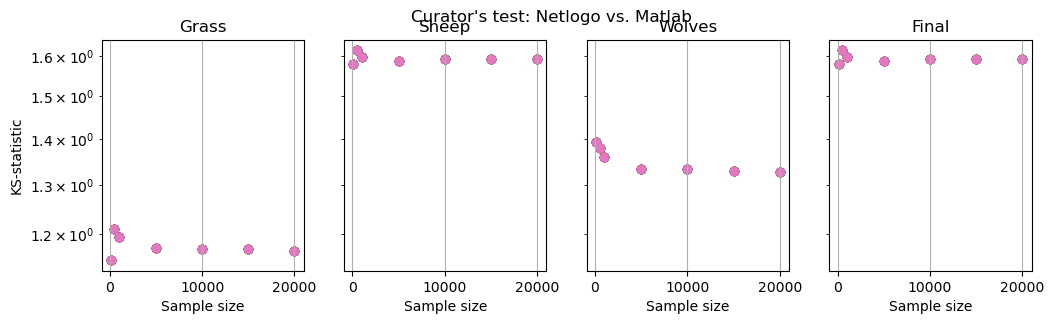

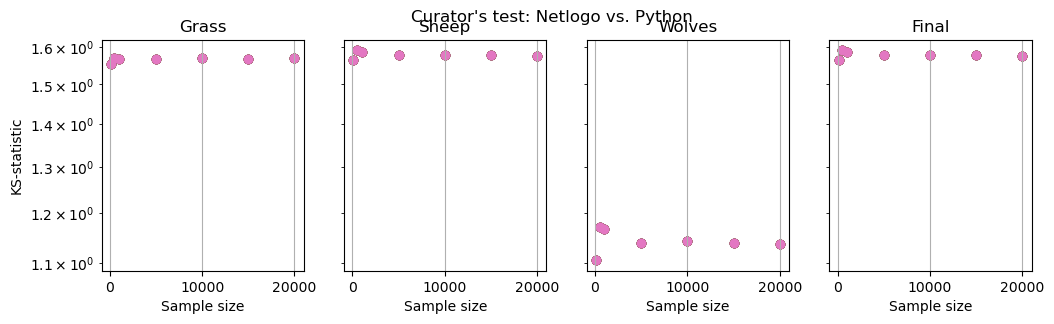

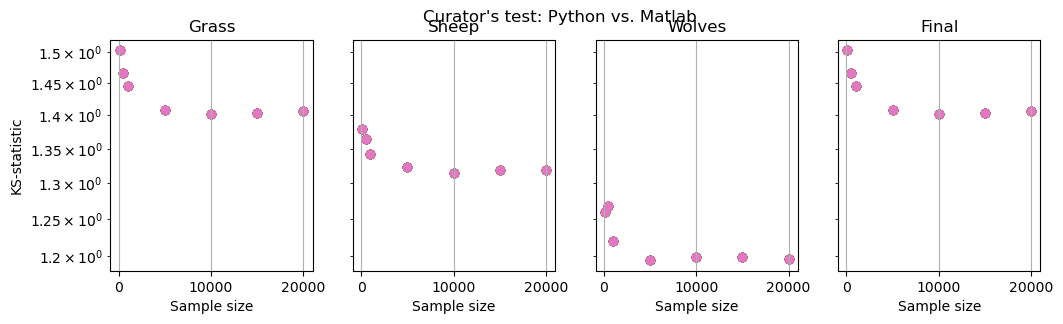

In [10]:
def plot_compare_experiment(_size_test, _kss_compare, fig_ax=None):
    num_vars = len(_kss_compare[_size_test[0]].keys())
    if fig_ax is None:
        _fig, _ax = plt.subplots(1, num_vars, figsize=(3*num_vars, 3), sharey=True)
    else:
        _fig, _ax = fig_ax
    
    for sz in _size_test:

        for j, k in enumerate(_kss_compare[sz].keys()):
            ax_j = _ax[j]
            ax_j.set_title(k)
            ax_j.set_xlabel('Sample size')
            ax_j.set_yscale('log')
            ax_j.grid(True)
            if j == 0:
                ax_j.set_ylabel('KS-statistic')

            ks_k = [_kss_compare[s][k] for s in _size_test]
            ax_j.scatter(_size_test, ks_k)
    
    return _fig, _ax

fig, ax = plot_compare_experiment(size_test, kss_nl_ml)
fig.suptitle('Curator\'s test: Netlogo vs. Matlab')
fig, ax = plot_compare_experiment(size_test, kss_nl_py)
fig.suptitle('Curator\'s test: Netlogo vs. Python')
fig, ax = plot_compare_experiment(size_test, kss_py_ml)
_ = fig.suptitle('Curator\'s test: Python vs. Matlab')